In [2]:
!date
import numpy as np
import pandas as pd

import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import theano.tensor as tt
import scipy.stats as stats
import xlrd

print(f"Running on PyMC3 v{pm.__version__}")
az.style.use("arviz-darkgrid")

Sat Feb  6 10:13:54 CST 2021
Running on PyMC3 v3.9.3


# GET AVG MONTHLY PAYS

In [ ]:
monthly = pd.read_csv("assets/monthly_spent.csv")
monthly.head()
avg_m_list = []

for i, row in monthly.iterrows(): 
    pinned_agent = row["AGENCY"]
    total = 0
    num = 0
    break
    
for i, row in monthly.iterrows(): 
    curr_agent = row["AGENCY"]
    if pinned_agent == curr_agent:
        total += row["TRANSACTION_AMOUNT"]
        num += 1
    else:
        avg_m_list.append([pinned_agent, total/num])
        pinned_agent = curr_agent
        total = row["TRANSACTION_AMOUNT"]
        num = 1

avg_m_list

avg_monthly = pd.DataFrame(avg_m_list, columns=['AGENCY', 'AVG_MONTHLY'])
# avg_monthly.to_csv('avg_monthly.csv')

In [4]:
avg_monthly = pd.read_csv("assets/avg_monthly.csv")

avg_monthly.head()

,Unnamed: 0,AGENCY,AVG_MONTHLY
0,0,Advisory Neighborhood Commission,81.740432
1,1,Alcoholic Beverage Regulation Administration,565.374832
2,2,Board of Elections & Ethics,497.389750
3,3,Board of Real Property Assessment & Appeals,554.026840
4,4,Child & Family Services Administration,583.823179


# GET AVG MONTHLY PAYS

In [ ]:
yearly = pd.read_csv("assets/yearly_spent.csv")
yearly.head()
avg_y_list = []

for i, row in yearly.iterrows(): 
    pinned_agent = row["AGENCY"]
    total = 0
    num = 0
    break
    
for i, row in yearly.iterrows(): 
    curr_agent = row["AGENCY"]
    if pinned_agent == curr_agent:
        
        total += row["TRANSACTION_AMOUNT"]
        num += 1
    else:
        avg_y_list.append([pinned_agent, total/num])
        pinned_agent = curr_agent
        total = row["TRANSACTION_AMOUNT"]
        num = 1

avg_yearly = pd.DataFrame(avg_y_list, columns=['AGENCY', 'AVG_YEARLY'])
# avg_yearly.to_csv('avg_yearly.csv')

In [5]:
avg_yearly = pd.read_csv("assets/avg_yearly.csv")

avg_yearly.head()

,Unnamed: 0,AGENCY,AVG_YEARLY
0,0,Advisory Neighborhood Commission,175.107961
1,1,Alcoholic Beverage Regulation Administration,605.240930
2,2,Board of Elections & Ethics,564.732992
3,3,Board of Real Property Assessment & Appeals,657.016728
4,4,Child & Family Services Administration,598.374793


In [28]:
avg_freq = pd.read_csv("assets/avg_freq.csv")

In [44]:
avg_freq.sort_values('AGENCY')
avg_monthly.sort_values('AGENCY')

,Unnamed: 0,AGENCY,AVG_MONTHLY
1,1,Alcoholic Beverage Regulation Administration,565.374832
2,2,Board of Elections & Ethics,497.389750
3,3,Board of Real Property Assessment & Appeals,554.026840
4,4,Child & Family Services Administration,583.823179
5,5,City Administrator/Deputy Mayor,399.636500
...,...,...,...
83,83,Office on Asian/Pacific Affairs,476.188578
84,84,Public Employee Relations Board,335.997195
85,85,Public Service Commission,467.895036
86,86,Serve DC,626.505657


ValueError: x and y must be the same size

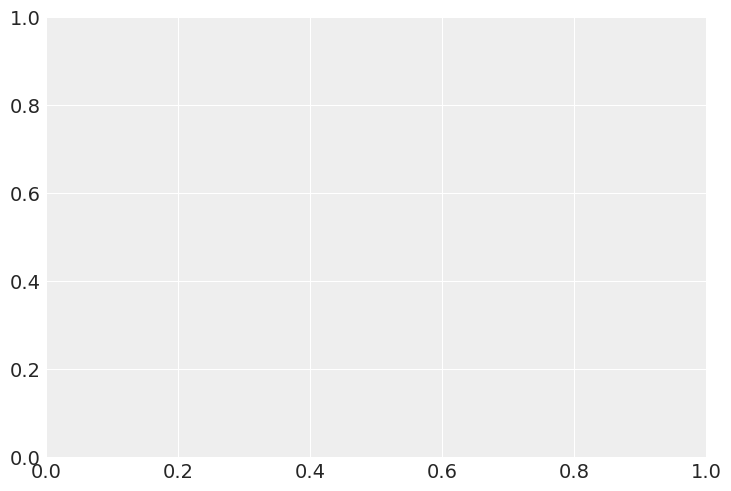

In [29]:
plt.scatter(avg_monthly['AVG_MONTHLY'], avg_freq['AVG_FREQUENCY'])
plt.title("");
plt.xlabel("Avg Spent Monthly")
plt.ylabel("Avg Frequency Bt Purchaeses, Monthly")

In [41]:
info = []
vals = []
for i, row in avg_monthly.iterrows():
    info.append([row['AGENCY'], row['AVG_MONTHLY']//100 * 100])
    vals.append(row['AVG_MONTHLY']//100 * 100)
print(vals)

[500.0, 400.0, 500.0, 500.0, 300.0, 100.0, 400.0, 400.0, 600.0, 400.0, 500.0, 800.0, 200.0, 400.0, 400.0, 400.0, 500.0, 500.0, 200.0, 400.0, 700.0, 300.0, 400.0, 400.0, 500.0, 500.0, 400.0, 700.0, 500.0, 500.0, 500.0, 500.0, 600.0, 400.0, 400.0, 800.0, 700.0, 600.0, 600.0, 300.0, 400.0, 0.0, 400.0, 500.0, 500.0, 700.0, 600.0, 100.0, 200.0, 600.0, 300.0, 400.0, 500.0, 400.0, 500.0, 500.0, 400.0, 500.0, 400.0, 400.0, 300.0, 500.0, 300.0, 500.0, 500.0, 300.0, 600.0, 500.0, 400.0, 100.0, 400.0, 500.0, 400.0, 500.0, 600.0, 500.0, 600.0, 600.0, 600.0, 800.0, 600.0, 400.0, 300.0, 400.0, 600.0, 300.0]


(array([ 1.,  3.,  3.,  9.,  0., 25., 25., 13.,  4.,  3.]),
 array([  0.,  80., 160., 240., 320., 400., 480., 560., 640., 720., 800.]),
 <a list of 10 Patch objects>)

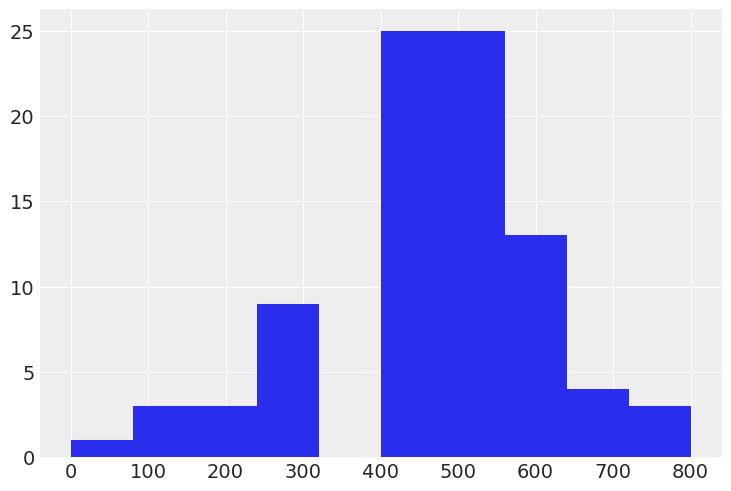

In [42]:
plt.hist(vals)

In [37]:
k = 3 # Number of clusters

model = pm.Model()
with model:

    p = pm.Dirichlet('p', a=np.array([1.0, 1.0, 1.0]), shape=k)
    
    switch = tt.switch(tt.min(p) < 0.1, -np.inf, 0)
    p_min_potential = pm.Potential("p_min_potential", switch) 
    sd = pm.Uniform("sd", lower=0, upper=20)  
    means = pm.Normal("means", mu=[200, 200, 200], sigma=100, shape=k)
    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(means[1] - means[0] < 0, -np.inf, 0)
        + tt.switch(means[2] - means[1] < 0, -np.inf, 0),
    )
    category = pm.Categorical("category", p=p)
    points = pm.Normal("obs", mu=means[category], sigma=sd, observed=vals)

In [36]:
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.CategoricalGibbsMetropolis(vars=[category])
    trace = pm.sample(10000, step=[step1, step2], tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [18]:
# Function to organize information from pm.summary(trace). Found in the depths of issues.
def get_lines_value_tuple(key, value, agg="mean"):
    
    key_name = key.split("__")
    
    return (key_name[0], 
            {f"{key_name[0]}_dim_0": int(key_name[1])} if len(key_name) > 1 else {}, 
            [value[agg]]) 

/Users/thomasyeum/miniconda3/envs/conda-env/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/Users/thomasyeum/miniconda3/envs/conda-env/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/traceplot.py:212: UserWarning: A valid var_name should be provided, found {'p[1]', 'p[0]', 'means[0]', 'means[2]', 'means[1]', 'category', 'p[2]'} expected from {'p', 'means', 'sd'}
  warnings.warn(


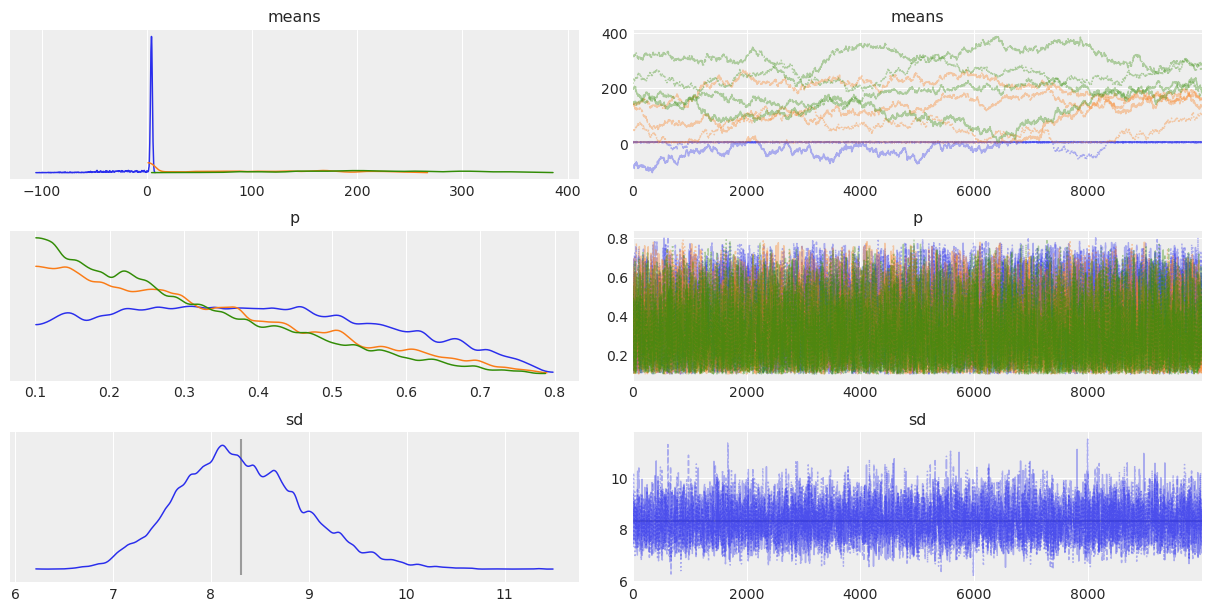

In [43]:
# Plot Trace Plot.
with model:
    lines = [get_lines_value_tuple(k, v, "mean") 
                 for k, v in pm.summary(trace).iterrows()]

    pm.traceplot(trace,
        varnames=['means','p','sd'], # Specify which variables to plot
        combined=True,  # combines all 4 chains into a single line.
        lines=lines) # Plots straight vertical lines onto graph (shows convergence).

plt.show()